## Imports

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

## Utilities

A helper function to plot fake images. This will be used to visualize sample outputs from the GAN while it is being trained.

In [2]:
def plot_multiple_images(images, n_cols=None):
    '''visualizes fake images'''
    display.clear_output(wait=False)  
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1

    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)

    plt.figure(figsize=(n_cols, n_rows))
    
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

## Download and Prepare the MNIST Dataset

You will first load the MNIST dataset. For this exercise, you will just be using the training images so you might notice that we are not getting the test split nor the training labels below. You will also preprocess these by normalizing the pixel values.

In [4]:
# load the train set of the MNIST dataset
(X_train, _), _ = keras.datasets.mnist.load_data()

# normalize pixel values
X_train = X_train.astype(np.float32) / 255
# reshape and rescale
X_train = X_train.reshape(-1, 28, 28, 1) * 2. - 1.

You will create batches of the train images so it can be fed to the model while training.

In [5]:
BATCH_SIZE = 128

dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

## Build the Model

In DCGANs, convolutional layers are predominantly used to build the generator and discriminator. You will see how the layers are stacked as well as the best practices shown below.

For the generator, we take in random noise and eventually transform it to the shape of the Fashion MNIST images. The general steps are:

- Feed the input noise to a dense layer.
- Reshape the output to have three dimensions. This stands for the (length, width, number of filters).
- Perform a deconvolution (with Conv2DTranspose), reducing the number of filters by half and using a stride of 2.
- The final layer upsamples the features to the size of the training images. In this case 28 x 28 x 1.

Notice that batch normalization is performed except for the final deconvolution layer. As best practice, selu is the activation used for the intermediate deconvolution while tanh is for the output. We printed the model summary so you can see the shapes at each layer.

In [6]:
codings_size = 32

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              206976    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 batch_normalization (Batch  (None, 7, 7, 128)         512       
 Normalization)                                                  
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        204864    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 64)        256       
 chNormalization)                                                
                                                        

Let's see a sample output of an untrained generator. As you expect, this will be just random points. After training, these will resemble digits from the MNIST dataset.

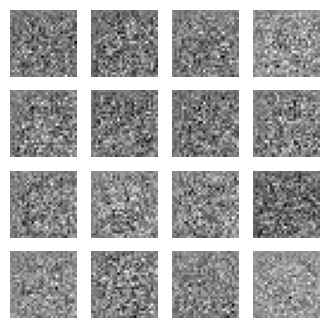

In [7]:
# generate a batch of noise input (batch size = 16)
test_noise = tf.random.normal([16, codings_size])

# feed the batch to the untrained generator
test_image = generator(test_noise)

# visualize sample output
plot_multiple_images(test_image, n_cols=4)

In [8]:
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6273      
                                                                 
Total params: 212865 (831.50 KB)
Trainable params: 212

We can append these two models to build the GAN.

In [9]:
gan = keras.models.Sequential([generator, discriminator])

## Configure Training Parameters

You will now prepare the models for training. You can measure the loss with binary_crossentropy because you're expecting labels to be either 0 (fake) or 1 (real).

In [10]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

## Train the Model

Next, you will define the training loop. This consists of two phases:

- Phase 1 - trains the discriminator to distinguish between fake or real data
- Phase 2 - trains the generator to generate images that will trick the discriminator

At each epoch, you will display a sample gallery of images to see the fake images being created by the generator. The details of how these steps are carried out are shown in the code comments below.

In [ ]:
def train_gan(gan, dataset, codings_size, n_epochs=50):
    """ Defines the two-phase training loop of the GAN
    Args:
      gan -- the GAN model which has the generator and discriminator
      dataset -- the training set of real images
      random_normal_dimensions -- dimensionality of the input to the generator
      n_epochs -- number of epochs
    """

    # get the two sub networks from the GAN model
    generator, discriminator = gan.layers

    # start loop
    for epoch in tqdm(range(n_epochs)):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))       
        for real_images in tqdm(dataset):
            # infer batch size from the training batch
            batch_size = real_images.shape[0]

            # Train the discriminator - PHASE 1
            # Create the noise
            noise = tf.random.normal(shape=[batch_size, codings_size])
            
            # Use the noise to generate fake images
            fake_images = generator(noise)
            
            # Create a list by concatenating the fake images with the real ones
            mixed_images = tf.concat([fake_images, real_images], axis=0)
            
            # Create the labels for the discriminator
            # 0 for the fake images
            # 1 for the real images
            discriminator_labels = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            
            # Ensure that the discriminator is trainable
            discriminator.trainable = True
            
            # Use train_on_batch to train the discriminator with the mixed images and the discriminator labels
            discriminator.train_on_batch(mixed_images, discriminator_labels)
            
            # Train the generator - PHASE 2
            # create a batch of noise input to feed to the GAN
            noise = tf.random.normal(shape=[batch_size, codings_size])

            # label all generated images to be "real"
            generator_labels = tf.constant([[1.]] * batch_size)

            # Freeze the discriminator
            discriminator.trainable = False

            # Train the GAN on the noise with the labels all set to be true
            gan.train_on_batch(noise, generator_labels)

        # plot the fake images used to train the discriminator
        plot_multiple_images(fake_images, 8)                     
        plt.show()      

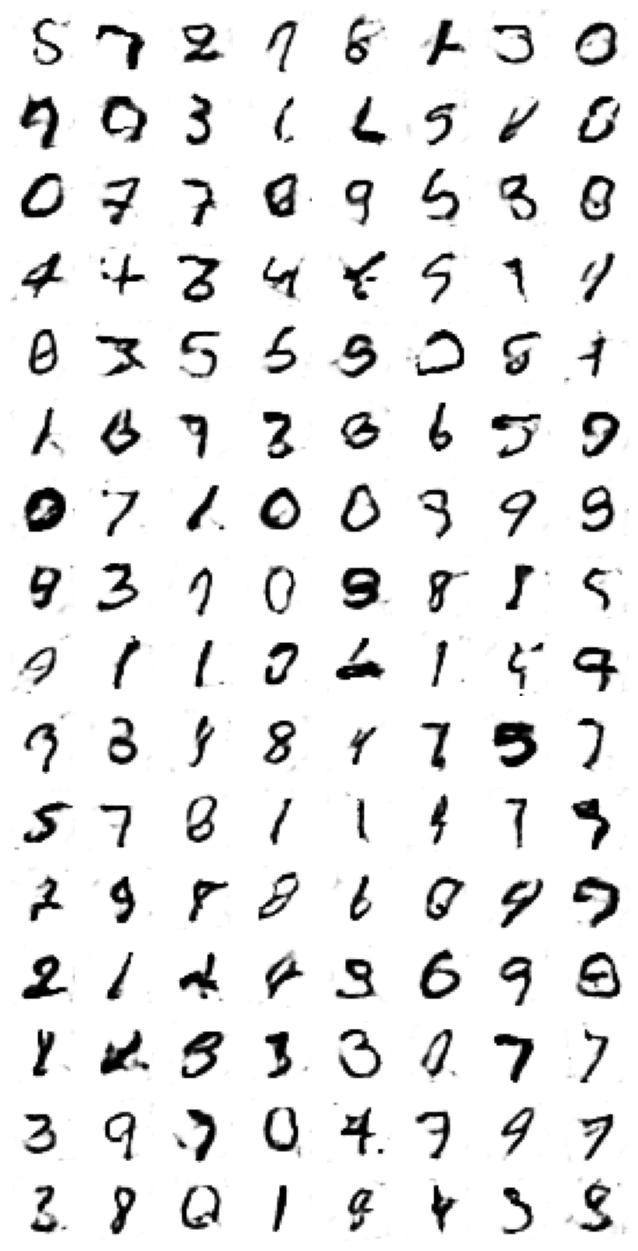

In [13]:
train_gan(gan, dataset, codings_size, n_epochs=20)